In [52]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
# train_x = torch.linspace(0,5,88)
# train_y = torch.sin(2*np.pi*train_x) + 0.05*torch.randn(train_x.size())

train_x, train_y, true_x, true_y = loadco2(test_size=0.6, subsample_rate=5)

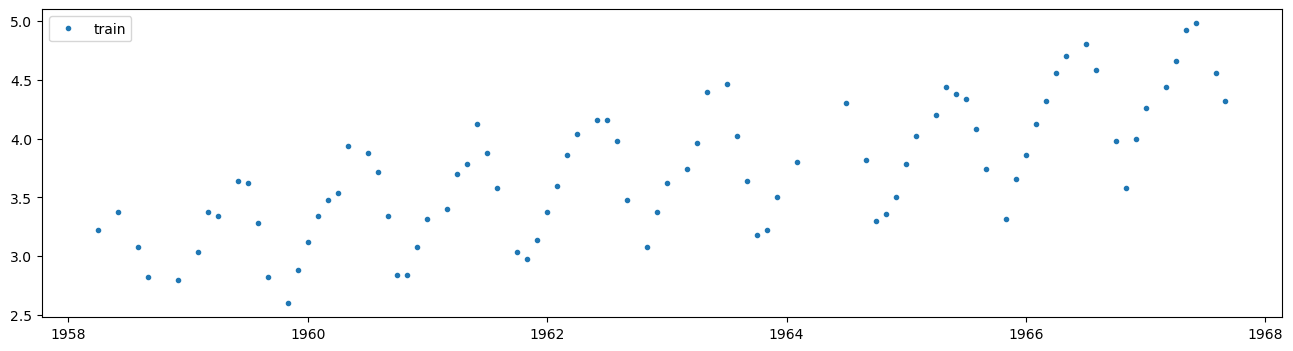

In [54]:

plt.figure(figsize=(16,4))
plt.plot(train_x, train_y,'.',label='train')
# plt.plot(test_x, test_y,'*',label='test')
plt.legend()

In [55]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = customkernel()
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [56]:
# %timeit -n1 -r1
import copy
training_iter = 3000

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# add tracker for best loss and its params
opt_loss = np.inf
opt_model = copy.deepcopy(model)
opt_idx = 0

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
    #     i + 1, training_iter, loss.item(),
    #     model.covar_module.base_kernel.lengthscale.item(),
    #     model.likelihood.noise.item()
    # ))
    curr_loss = loss.item()
    if (curr_loss < opt_loss) and (i > 200):
        opt_loss = curr_loss
        opt_model = copy.deepcopy(model)
        opt_idx = i + 1
    optimizer.step()
    


In [57]:
# model = opt_model
print('\n * %d th iteration gave optimal loss of %.3f' % (opt_idx, opt_loss))



 * 2998 th iteration gave optimal loss of 0.586


In [58]:
# for k in model.covar_module.sub_kernels():
#     print('\n', k)
#     for param_name, param in k.named_parameters():
#         print(f'Parameter name: {param_name:42} value = {param.item()}')

In [67]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(1958.2,2002,1000)
    # test_x = torch.linspace(0,10,1000)
    # test_x = 0.2*(test_x - 1950)
    observed_pred = likelihood(model(test_x))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


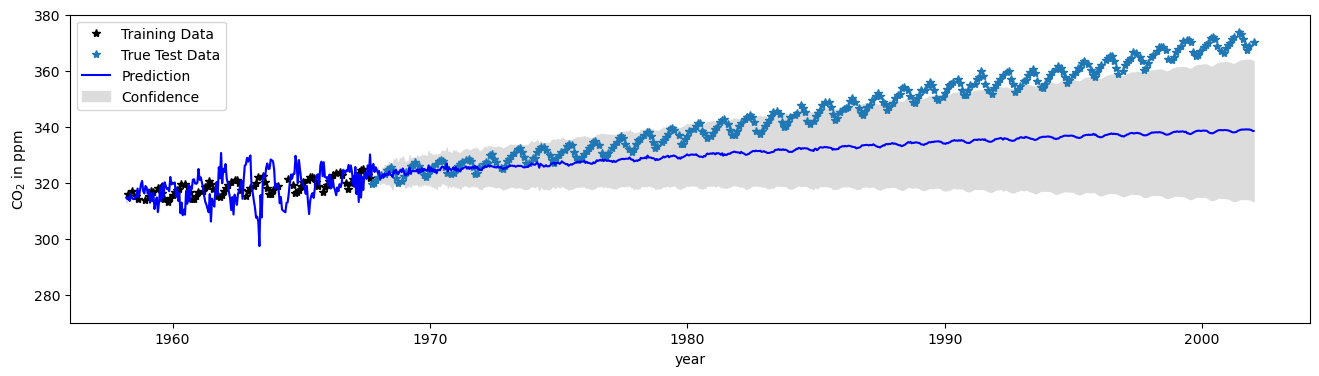

In [70]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(16, 4))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), 300+(5*train_y.numpy()), 'k*')
    ax.plot(true_x.numpy(), 300+(5*true_y.numpy()), '*')
    
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), 300+(5*observed_pred.mean.numpy()), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), 300+(5*lower.numpy()), 300+(5*upper.numpy()), color="gainsboro")
    ax.set_ylim([270, 380])
    # ax.legend(['Training Data', 'Prediction', 'Confidence'])
    ax.legend(['Training Data', 'True Test Data', 'Prediction', 'Confidence'])
    
    plt.xlabel("year")
    _ = plt.ylabel("CO$_2$ in ppm")
    
plt.savefig('gpr-co2-custom.eps', format='eps')